<a href="https://colab.research.google.com/github/saachi-surana/UW-PHYS417/blob/main/Lab9_(Stellar_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 Report: Final Project Codebase
## Project Title: Stellar Classification with Fully Connected Networks
## Group Members: Ashwika Sharma and Saachi Surana

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
# Load the dataset
# Note: Ensure 'star_classification.csv' is in the same directory
try:
    star_classification = pd.read_csv('star_classification.csv')
    print("Data Loaded Successfully")
    print(star_classification.head())
    print("Unique Classes:", star_classification['class'].unique())
    print("Columns:", star_classification.columns)
except FileNotFoundError:
    print("Error: 'star_classification.csv' not found. Please ensure the dataset is present.")
    # Creating dummy data for syntax checking if file is missing (Optional)
    # star_classification = pd.DataFrame(np.random.rand(100, 18), columns=['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift', 'plate', 'MJD', 'fiber_ID'])
    # star_classification['class'] = 'STAR'

Data Loaded Successfully
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354      

In [4]:
# Cleaning Data
# Corrected column names to match those in the CSV file
columns_to_drop = ['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID',
                   'spec_obj_ID', 'plate', 'MJD', 'fiber_ID']

# Only drop columns that are present in the DataFrame
existing_columns = [col for col in columns_to_drop if col in star_classification.columns]
star_classification = star_classification.drop(columns=existing_columns)

print("Data after dropping columns:")
print(star_classification.head())

y_targets = star_classification['class']
x_features = star_classification.drop(columns=['class'])

print("Training Features (x_train):", x_features.shape)
print("Training Targets (y_train):", y_targets.shape)
print(x_features.iloc[:10, :], y_targets.iloc[:10])

Data after dropping columns:
        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

    class  redshift  
0  GALAXY  0.634794  
1  GALAXY  0.779136  
2  GALAXY  0.644195  
3  GALAXY  0.932346  
4  GALAXY  0.116123  
Training Features (x_train): (100000, 8)
Training Targets (y_train): (100000,)
        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  1

In [5]:
# Scaling Data
# Creates instance of StandardScaler class
scaler = StandardScaler()

# Fit the scaler on the training and test data (calculates mean and standard deviation)
x_features = scaler.fit_transform(x_features)

In [6]:
# Divide into training and validation sets
# Based on the notebook, slicing 80k for train, 20k for val
training_features = x_features[:80000]
training_targets = y_targets[:80000]

validation_features = x_features[80000:100000]
validation_targets = y_targets[80000:100000]

print("Train shape:", training_features.shape)
print("Train targets shape:", training_targets.shape)
print("Val shape:", validation_features.shape)
print("Val targets shape:", validation_targets.shape)

# Reshape training and validation features for the CNN (Channels first for PyTorch Conv1d)
# Shape becomes: (Batch_Size, Channels, Length)
training_features = training_features.reshape(-1, 1, training_features.shape[1])
validation_features = validation_features.reshape(-1, 1, validation_features.shape[1])

Train shape: (80000, 8)
Train targets shape: (80000,)
Val shape: (20000, 8)
Val targets shape: (20000,)


In [7]:
class StellarClassificationCNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StellarClassificationCNN, self).__init__()
        # 1D layer, 1 input channel, 32 output channels
        self.conv1 = torch.nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.relu1 = torch.nn.ReLU()
        # Max pooling
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2)

        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2)

        # FCN to make predictions
        # Calculate flattened size: 64 channels * (input_dim // 4 due to 2 poolings)
        self.fc = torch.nn.Linear(64 * (input_dim // 4), output_dim)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        # Flatten to pass through FCN
        x = x.view(-1, 64 * (x.shape[2]))
        x = self.fc(x)
        return x

In [8]:
# Using star_classification['class'] unique count for output dimension
unique_classes = star_classification['class'].unique()
model = StellarClassificationCNN(training_features.shape[2], len(unique_classes))

learning_rate = 0.0005
epochs = 100
batchsize = 64

In [9]:
# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to {device}")
print(model)


Model moved to cpu
StellarClassificationCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [11]:
# Lists to track metrics
train_loss_list = np.zeros((epochs, ))
validation_accuracy_list = np.zeros((epochs,))

In [12]:
# Encode Targets (String -> Int)
label_encoder = LabelEncoder()
training_targets_encoded = label_encoder.fit_transform(training_targets)
validation_targets_encoded = label_encoder.transform(validation_targets)

In [13]:
print("Starting Training...")

for epoch in range(epochs):
    # Create a random permutation of the training data indices
    permutation = torch.randperm(training_features.shape[0])

    # Iterate over the training data in batches
    for i in range(0, training_features.shape[0], batchsize):
        # Get indices
        indices = permutation[i:i + batchsize]

        # Get batch features/targets
        batch_features = torch.tensor(training_features[indices], dtype=torch.float32)
        batch_targets = torch.tensor(training_targets_encoded[indices], dtype=torch.long)

        if torch.cuda.is_available():
            batch_features = batch_features.cuda()
            batch_targets = batch_targets.cuda()

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_features)

        # Calculate loss
        loss = loss_func(outputs, batch_targets)

        # Backward pass
        loss.backward()
        optimizer.step()

    # Store loss
    train_loss_list[epoch] = loss.item()
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    # Validation
    with torch.no_grad():
        validation_features_tensor = torch.tensor(validation_features, dtype=torch.float32)
        validation_targets_tensor = torch.tensor(validation_targets_encoded[:len(validation_features)], dtype=torch.long)

        if torch.cuda.is_available():
            validation_features_tensor = validation_features_tensor.cuda()
            validation_targets_tensor = validation_targets_tensor.cuda()

        validation_outputs = model(validation_features_tensor)
        _, predicted_classes = torch.max(validation_outputs, 1)

        total_validation_samples = validation_targets_tensor.size(0)
        correct_predictions = (predicted_classes == validation_targets_tensor).sum().item()
        accuracy = correct_predictions / total_validation_samples

        validation_accuracy_list[epoch] = accuracy
        print(f'Validation Accuracy: {accuracy:.4f}')

Starting Training...
Epoch [1/100], Loss: 0.1365
Validation Accuracy: 0.9411
Epoch [2/100], Loss: 0.2479
Validation Accuracy: 0.9480
Epoch [3/100], Loss: 0.0305
Validation Accuracy: 0.9558
Epoch [4/100], Loss: 0.1470
Validation Accuracy: 0.9527
Epoch [5/100], Loss: 0.1210
Validation Accuracy: 0.9604
Epoch [6/100], Loss: 0.1740
Validation Accuracy: 0.9647
Epoch [7/100], Loss: 0.1177
Validation Accuracy: 0.9625
Epoch [8/100], Loss: 0.2356
Validation Accuracy: 0.9665
Epoch [9/100], Loss: 0.1794
Validation Accuracy: 0.9668
Epoch [10/100], Loss: 0.0717
Validation Accuracy: 0.9670
Epoch [11/100], Loss: 0.0996
Validation Accuracy: 0.9651
Epoch [12/100], Loss: 0.0453
Validation Accuracy: 0.9654
Epoch [13/100], Loss: 0.0801
Validation Accuracy: 0.9676
Epoch [14/100], Loss: 0.1368
Validation Accuracy: 0.9674
Epoch [15/100], Loss: 0.1385
Validation Accuracy: 0.9678
Epoch [16/100], Loss: 0.0322
Validation Accuracy: 0.9676
Epoch [17/100], Loss: 0.0345
Validation Accuracy: 0.9675
Epoch [18/100], Los

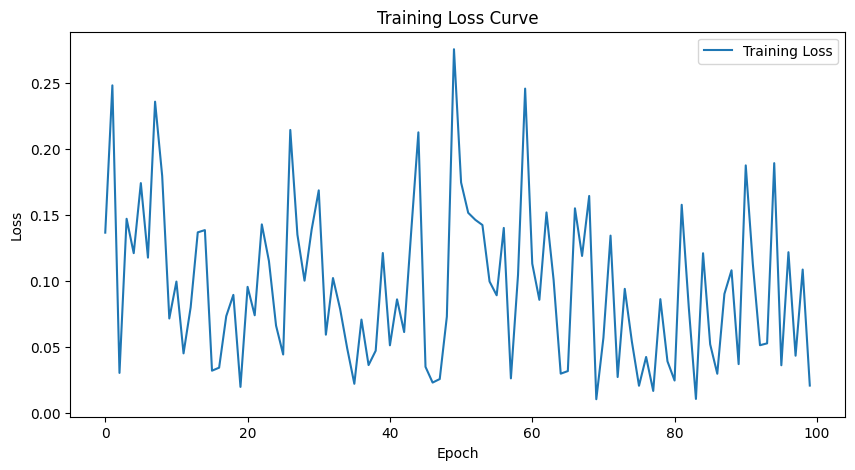

In [14]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

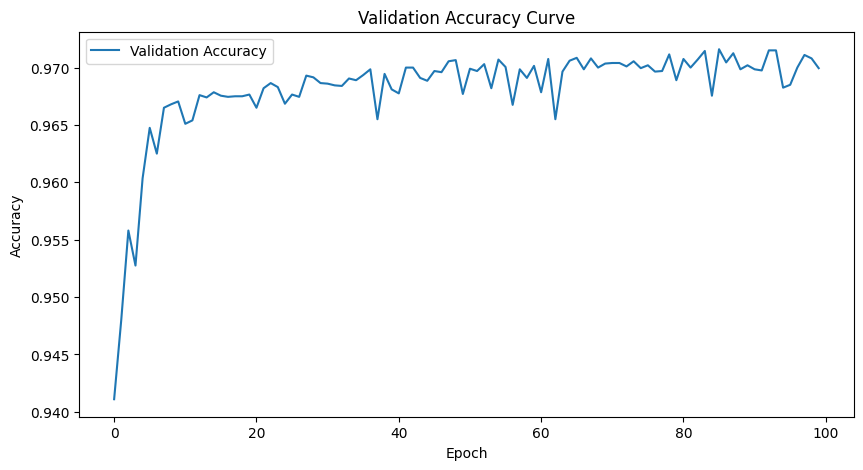

In [15]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()